In [2]:
pip install opencv_python

You should consider upgrading via the 'c:\Users\sagar\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')

In [6]:
train_path='DATASET/TRAIN'
test_path='DATASET/TEST'

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.utils import plot_model
from glob import glob

In [9]:
from cv2 import cvtColor
x_data=[]
y_data=[]
for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array=cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append({category.split('/')[-1]})
data=pd.DataFrame({'image':x_data,'label':y_data})

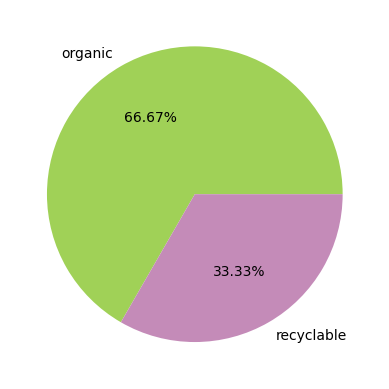

In [12]:
data={'organic':10,'recyclable':5}
colors=['#a0d157','#c48bb8']
plt.pie(data.values(),labels=data.keys(),colors=colors,autopct='%0.2f%%')
plt.show()